In [170]:
import os
from glob import glob
import json
from dataclasses import dataclass
import re
import ast
from matplotlib import ticker, lines, pyplot


In [171]:
root_dir = '/home/dominik/Nextcloud/020_Masterstudium/Language Technology/LT2402_Master Thesis/experiments/language-games/'
# root_dir = "/home/dominik/Development/MLT_Master-Thesis/out/"

@dataclass
class Model:
    folder: str
    name: str
    metric: tuple[str, str]
    is_percent: bool
    y_limit: tuple[int, int]
    modifier: int = 1

models = [
    Model(folder='discriminator',
          name='Discriminator',
          metric=('acc', 'Accuracy'),
          is_percent=True,
          y_limit=(0,100)),
    Model(folder='bb_caption_generator',
          name='RE generator',
          metric=('loss', 'Loss'),
          is_percent=False,
          y_limit=(0,2)),
    Model(folder='bb_one-hot_generator',
          name='Attribute generator',
          metric=('shape_accuracy', 'Accuracy shape'),
          is_percent=True,
          y_limit=(0,100)),
    Model(folder='bb_attention_predictor',
          name='Attention reference resolver',
          metric=('bb_probability_mass', 'Probability mass'),
          is_percent=True,
          y_limit=(0,100)),
]
datasets = [('dale-2', 'Dale-2'), ('dale-5', 'Dale-5'), ('colour', 'CLEVR color')]
variables = ['|V|', 'n']

In [172]:
@dataclass
class Run:
    baseline: bool
    vocab_size: int
    max_len: int
    games_per_epoch: int
    train_epochs: list[dict]
    test_epochs: list[dict]


In [173]:
def get_runs(model, dataset):
    runs: list[Run] = []

    for run in glob(f"{os.path.join(root_dir, model)}/*{dataset}*"):
        folder_name = os.path.split(run)[-1]

        pattern = r"_([^_]+)((_[\de\-\.]+)*)$"
        match = re.search(pattern, folder_name)
        if match:
            dataset = match.group(1)
            variable_values = [
                int(var) for var in match.group(2).split("_") if var != ""
            ]
        else:
            raise ValueError('folder name not properly formatted')

        with open(os.path.join(run, 'log.txt'), 'r', encoding='utf-8') as f:
            lines = f.readlines()
            for index, line in enumerate(lines):
                if ' batches_per_epoch' in line:
                    batches_per_epoch = int(re.search(r' batches_per_epoch=(\d+),', line).group(1))
                if ' batch_size' in line:
                    batch_size = int(re.search(r' batch_size=(\d+),', line).group(1))

                if line.startswith('appendix: '):
                    variable_names = ast.literal_eval(line.removeprefix("appendix: "))
                    break
            variables = dict(zip(variable_names, variable_values))
            
            epochs = [json.loads(line) for line in lines[index:] if line.startswith('{')]
            runs.append(Run(baseline='baseline' in folder_name,
                            vocab_size=variables['vocab_size'],
                            max_len=variables['max_len'],
                            games_per_epoch=batches_per_epoch * batch_size,
                            train_epochs=[epoch for epoch in epochs if epoch['mode'] == 'train'],
                            test_epochs=[epoch for epoch in epochs if epoch['mode'] == 'test'])
                        )
            
    return runs


In [174]:
def plot_learning_curve(runs: list[Run],
                        variable: str,
                        model: Model,
                        dataset: str):
    colors = ['#88F7E2', '#44D492', '#F5EB67', '#FFA15C', '#FA233E', '#81b0de']
    vocab_colors = {vocab_size: index for index, vocab_size in enumerate(sorted(list({run.vocab_size for run in runs})))}
    max_len_colors = {max_len: index for index, max_len in enumerate(sorted(list({run.max_len for run in runs})))}

    for run in runs:
        n_train_games = [float(epoch['epoch']) * run.games_per_epoch for epoch in run.train_epochs]

        if model.is_percent:
            train_losses = [float(epoch[model.metric[0]]) * 100 for epoch in run.train_epochs]
        else:
            train_losses = [float(epoch[model.metric[0]]) for epoch in run.train_epochs]

        if run.baseline:
            zorder = 100
            color='black'
        else:
            zorder = None
            if variable == '|V|':
                color = colors[vocab_colors[run.vocab_size]]
            elif variable == 'n':
                color = colors[max_len_colors[run.max_len]]
            else:
                color = None

        pyplot.plot(n_train_games, train_losses, color=color, zorder=zorder)

    max_games = 100 * run.games_per_epoch
    pyplot.xlabel('Games')
    pyplot.xlim(0,max_games)
    pyplot.gca().xaxis.set_major_locator(ticker.MultipleLocator(20000))
    pyplot.gca().xaxis.set_minor_locator(ticker.MultipleLocator(5000))
    pyplot.gca().grid(axis='x', which='minor')

    pyplot.ylabel(model.metric[1])
    pyplot.ylim(*model.y_limit)
    pyplot.gca().yaxis.set_major_locator(ticker.MultipleLocator(model.y_limit[1] / 10))
    pyplot.gca().yaxis.set_minor_locator(ticker.MultipleLocator(model.y_limit[1] / 20))
    pyplot.gca().grid(axis='y', which='minor')
    if model.is_percent:
        pyplot.gca().yaxis.set_major_formatter(ticker.PercentFormatter())

    if variable == '|V|':
        handles = [lines.Line2D([], [], color=colors[index], label=f"|V| = {var}") for var, index in vocab_colors.items() if var != 1]
    elif variable == 'n':
        handles = [lines.Line2D([], [], color=colors[index], label=f"n = {var}") for var, index in max_len_colors.items()]
    else:
        handles = []
        
    handles.insert(0,lines.Line2D([], [], color='black', label=f"baseline"))
    pyplot.legend(handles=handles, ncol=2)
    pyplot.title(f"{model.name} ({dataset})")
    pyplot.grid()
    pyplot.show()

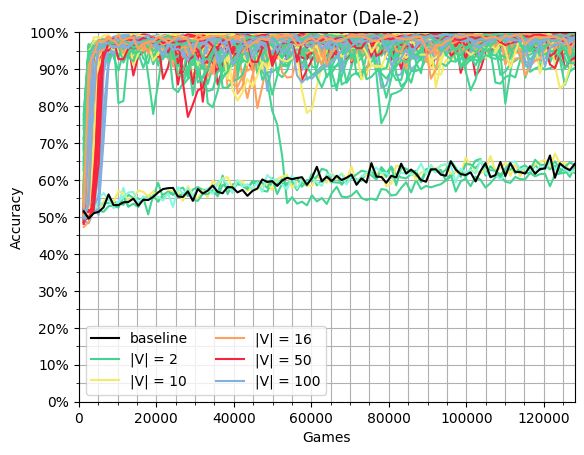

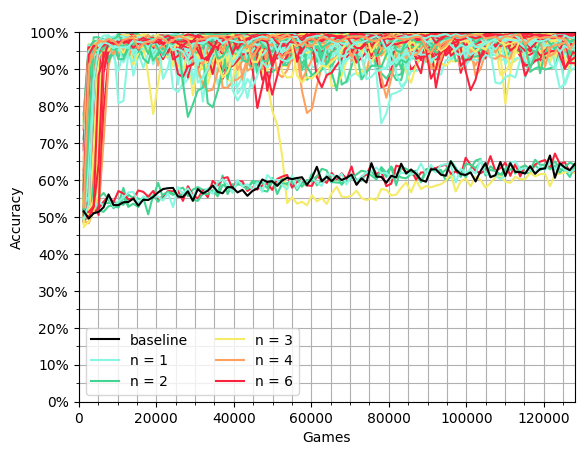

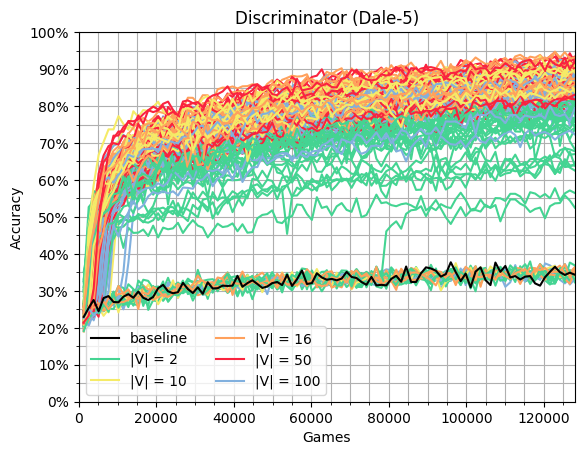

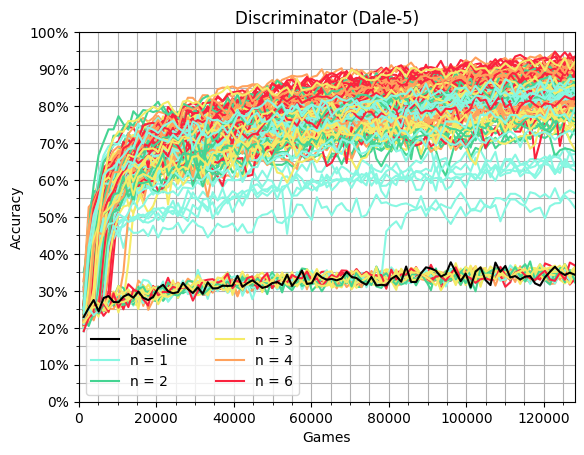

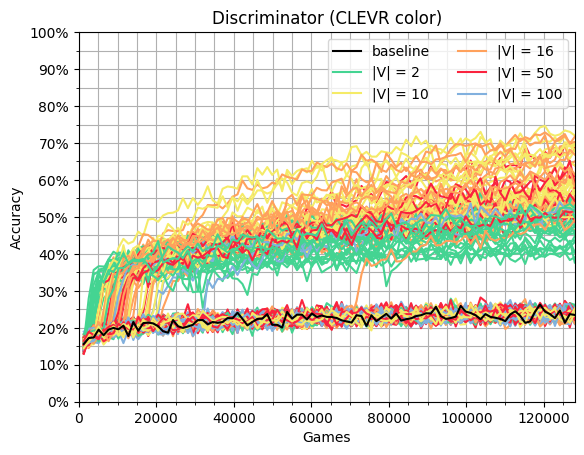

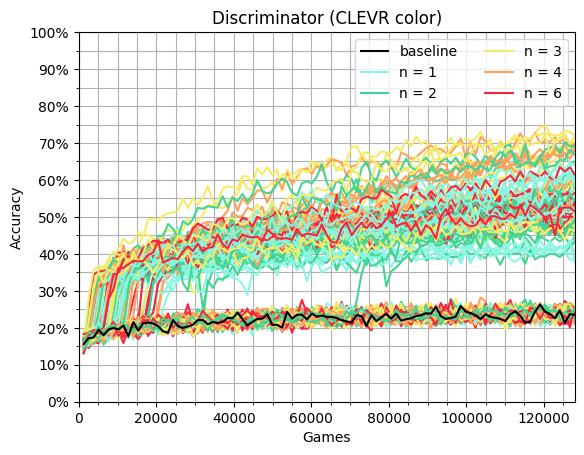

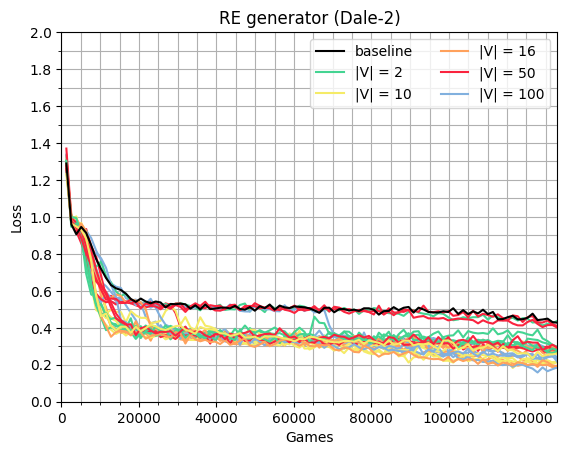

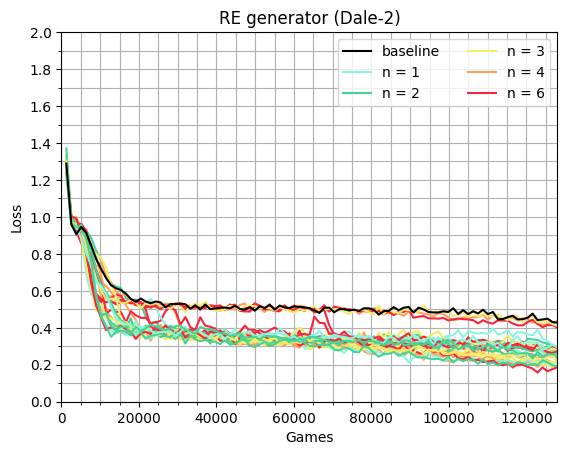

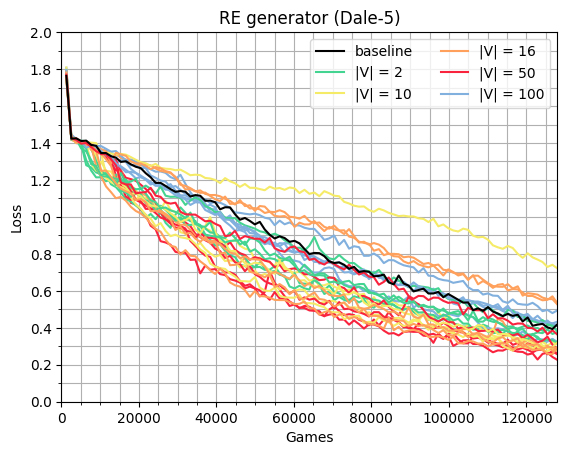

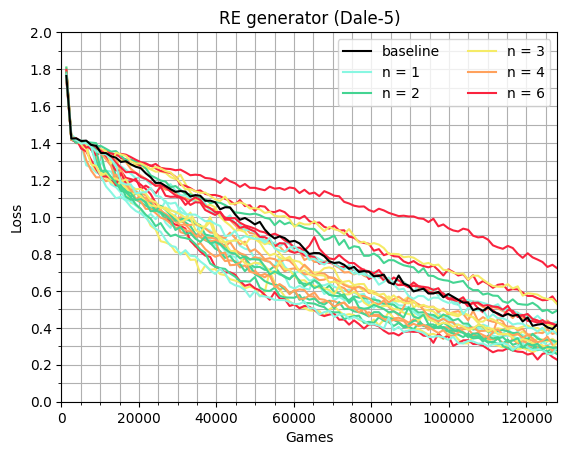

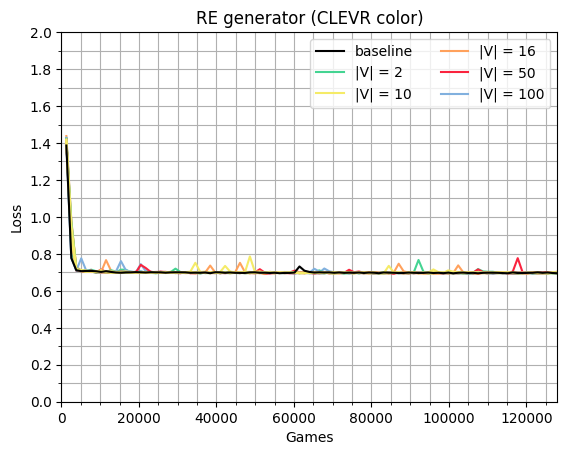

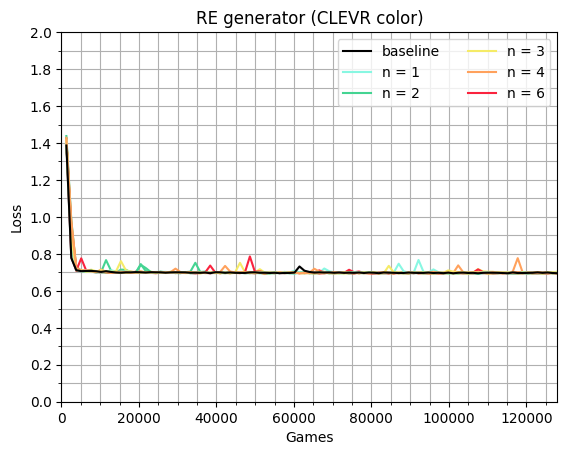

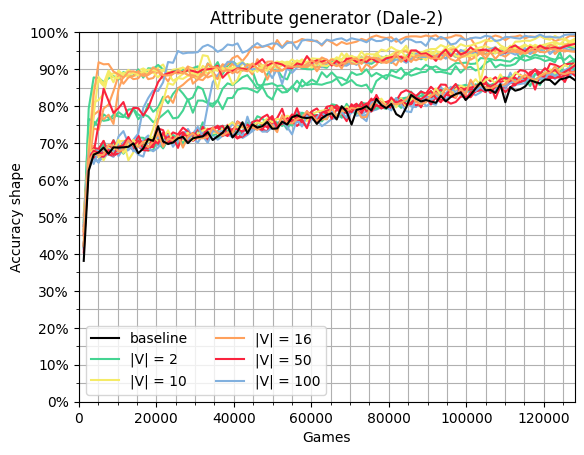

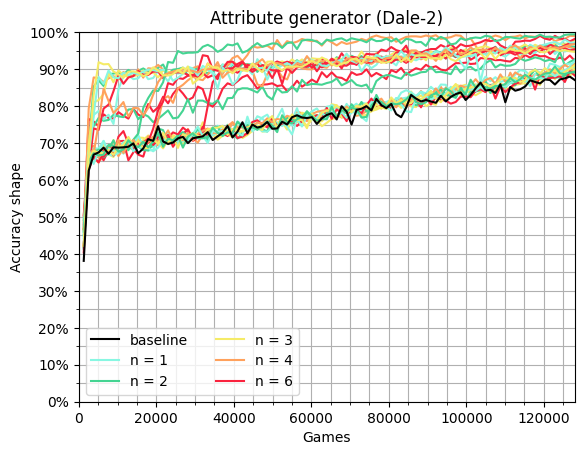

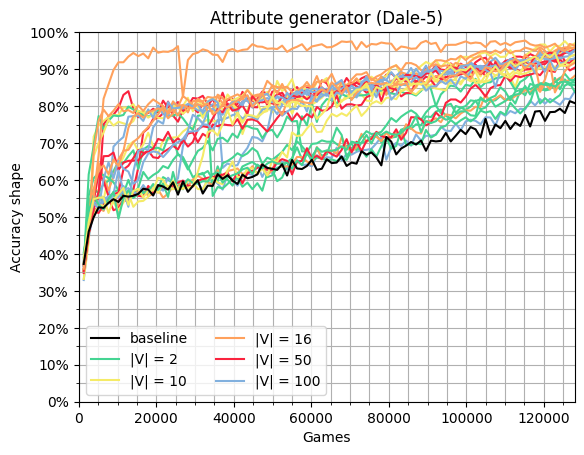

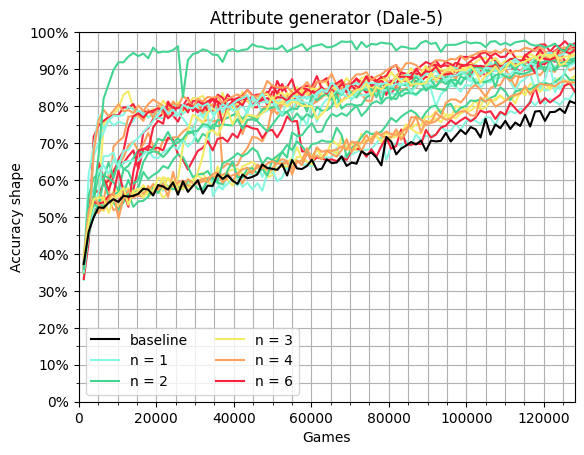

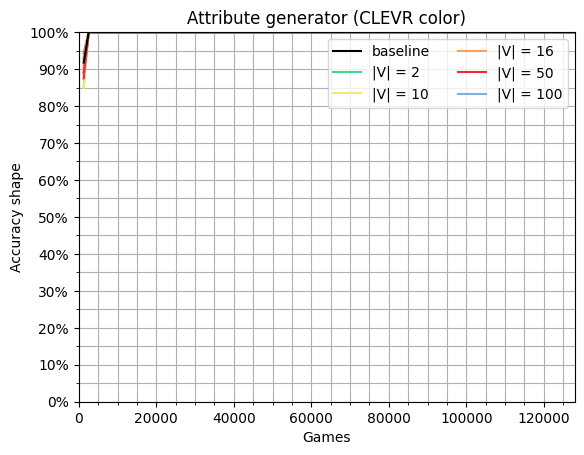

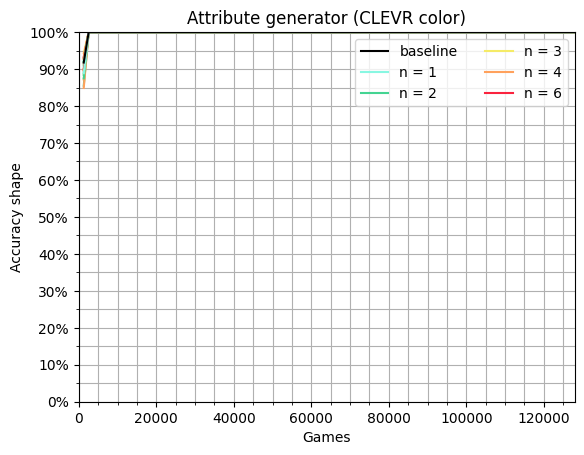

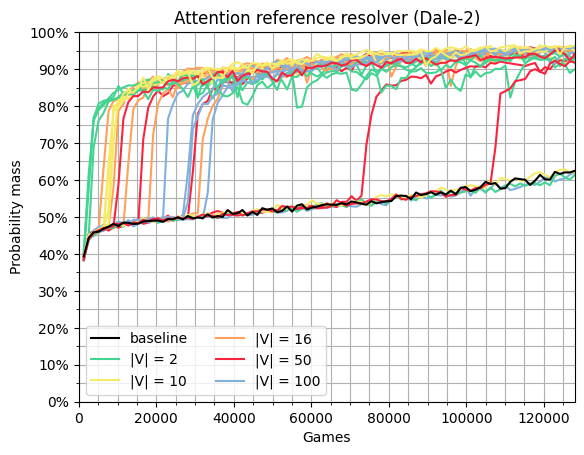

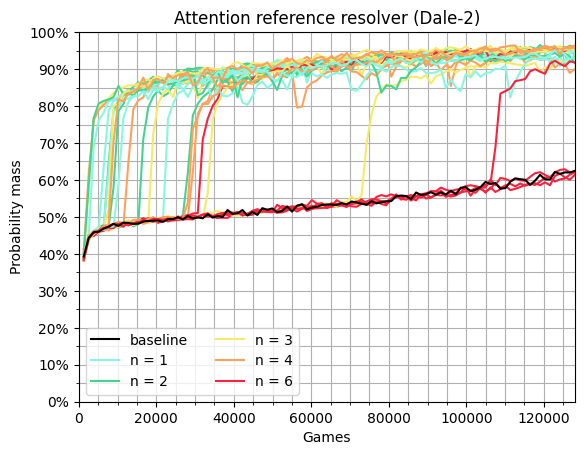

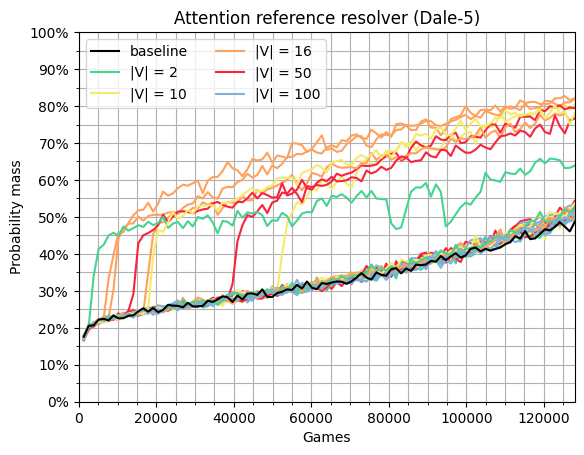

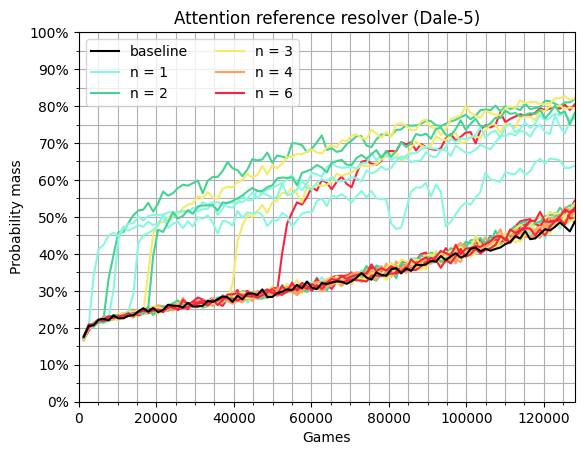

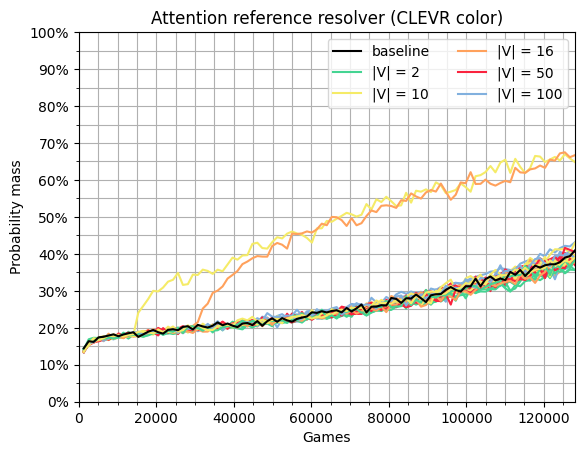

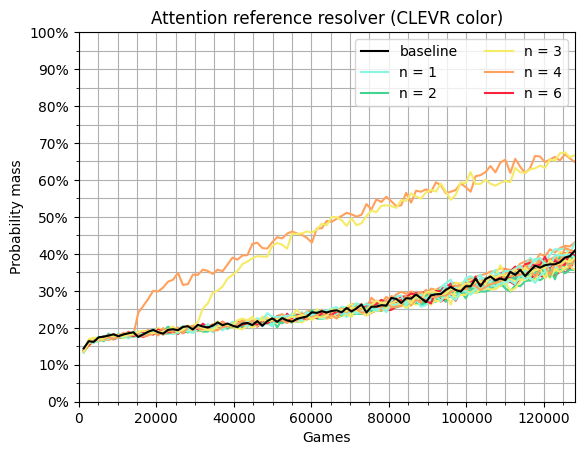

In [175]:
for model in models:
    for dataset in datasets:
        for variable in variables:
            runs = get_runs(model.folder, dataset[0])
            plot_learning_curve(runs, variable, model, dataset[1])

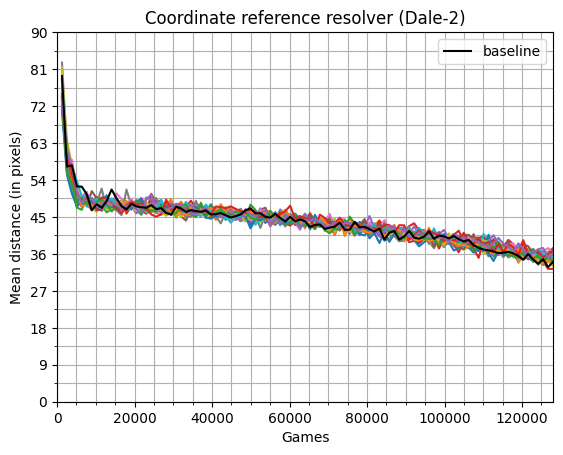

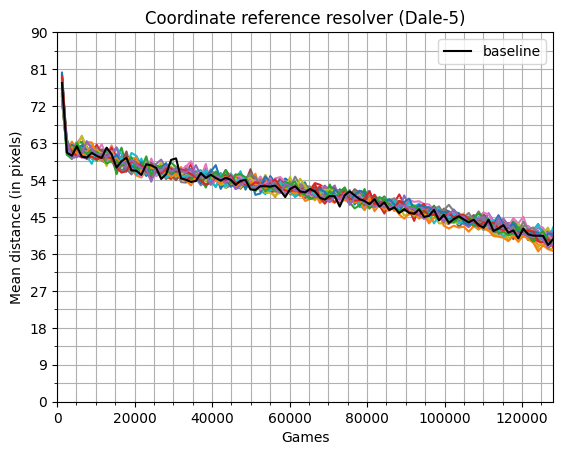

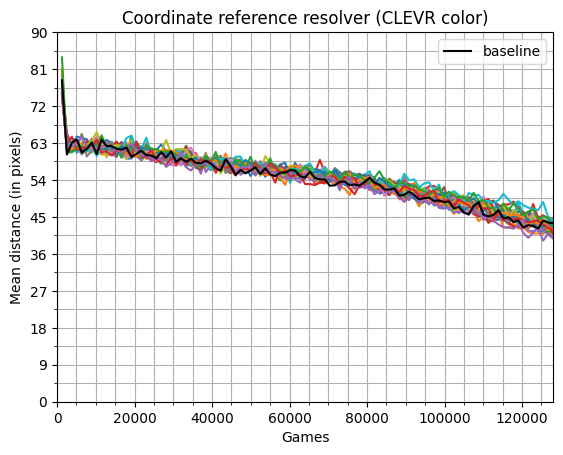

In [176]:
model = Model(folder='bb_coordinate_predictor',
              name='Coordinate reference resolver',
              metric=('loss', 'Mean distance (in pixels)'),
              is_percent=False,
              y_limit=(0,90),
              modifier=100)

for dataset in datasets:
    runs = get_runs(model.folder, dataset[0])
    plot_learning_curve(runs, '', model, dataset[1])